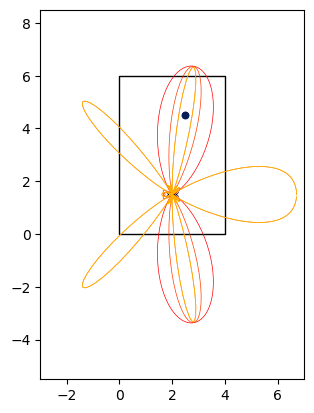

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

# Create a 4 by 6 metres shoe box room
room = pra.ShoeBox([4,6])

# Add a source somewhere in the room
room.add_source([2.5, 4.5])

# Create a linear array beamformer with 4 microphones
# with angle 0 degrees and inter mic distance 10 cm
R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
room.add_microphone_array(pra.Beamformer(R, room.fs))

# Now compute the delay and sum weights for the beamformer
room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# plot the room and resulting beamformer
room.plot(freq=[1000, 2000, 4000, 8000], img_order=0)

plt.xlim([-3, 7]) ###
plt.ylim([-5.5, 8.5]) ###

plt.show()

The content below comes from https://nbviewer.org/github/LCAV/pyroomacoustics/blob/master/notebooks/pyroomacoustics_demo.ipynb, with data from the [CMU_ARCTIC database](http://www.festvox.org/cmu_arctic/dbs_bdl.html), taking the first 5 samples from a and b sublabels of the US bdl (US male) group.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import os

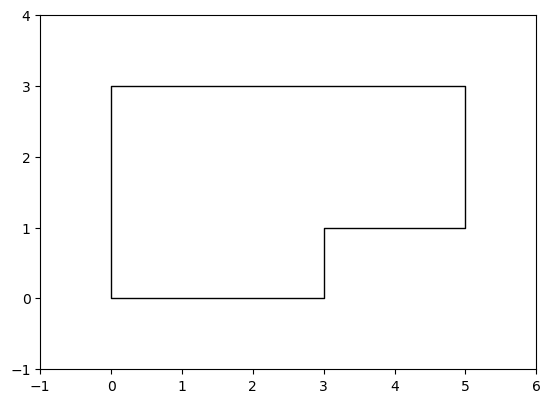

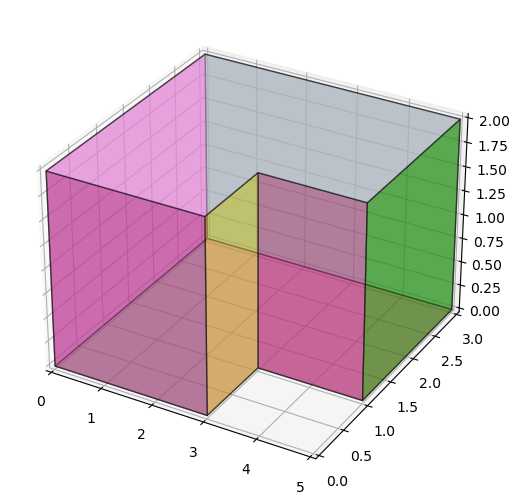

In [14]:
corners = np.array([[0,0],[0,3],[5,3],[5,1],[3,1],[3,0]]).T

room = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1,6])
ax.set_ylim([-1,4]);

room.extrude(2.)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

In [15]:
### Loading audio data, referring to forum post below
# https://stackoverflow.com/questions/27659563/reading-wav-files-in-all-subdirectories

def load_audio(data_dir):
    '''
    Reads audio from given directory path, returning the sampling frequencies and signals in respective lists.
    
    Inputs:
    data_dir (string): string of directory path of audio sample folder

    Output:
    fs_s (Python list(int16)): list of sampling frequency for each sample
    signals (Python list(int16)): list of signals in form of integers
    '''
    
    fs_s = []
    signals = []

    for root,sub,files in os.walk(data_dir):
        files = sorted(files)
        for f in files:
            fs, signal = wavfile.read(os.path.join(root, f))
            fs_s.append(fs)
            signals.append(signal)
                 
    return fs_s, signals

data_dir=r'C:\Users\mondo\Downloads\pyroomfiddling\abridged_samples'
fs_s, signals = load_audio(data_dir)

[] []
[16000, 16000, 16000, 16000, 16000, 16000, 16000, 16000, 16000, 16000] [array([ -38,  -15,  -19, ..., -128, -144, -148], dtype=int16), array([325, 337, 349, ...,  80,  77,  86], dtype=int16), array([62, 65, 81, ..., 39, 29, 23], dtype=int16), array([-295, -274, -269, ...,  167,  189,  185], dtype=int16), array([ 189,  169,  149, ..., -104,  -96, -100], dtype=int16), array([-76, -76, -82, ...,  15,  12,   6], dtype=int16), array([-17, -39, -31, ...,  29,  24,  21], dtype=int16), array([-15, -15, -29, ...,   3,  13,   0], dtype=int16), array([-259, -265, -288, ...,  -48,  -38,  -45], dtype=int16), array([-192, -186, -186, ..., -116, -102, -102], dtype=int16)]


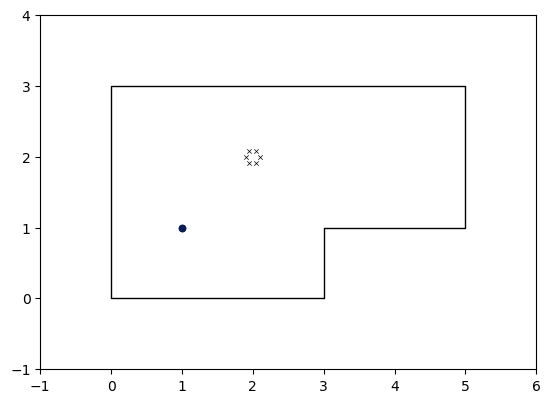

In [21]:
### Set up room with sound source and microphone array

room = pra.Room.from_corners(corners, fs=fs_s[0], ray_tracing=True, air_absorption=True)
room.add_source([1.,1.], signal=signals[0])

R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([-1,6])
ax.set_ylim([-1,4]);

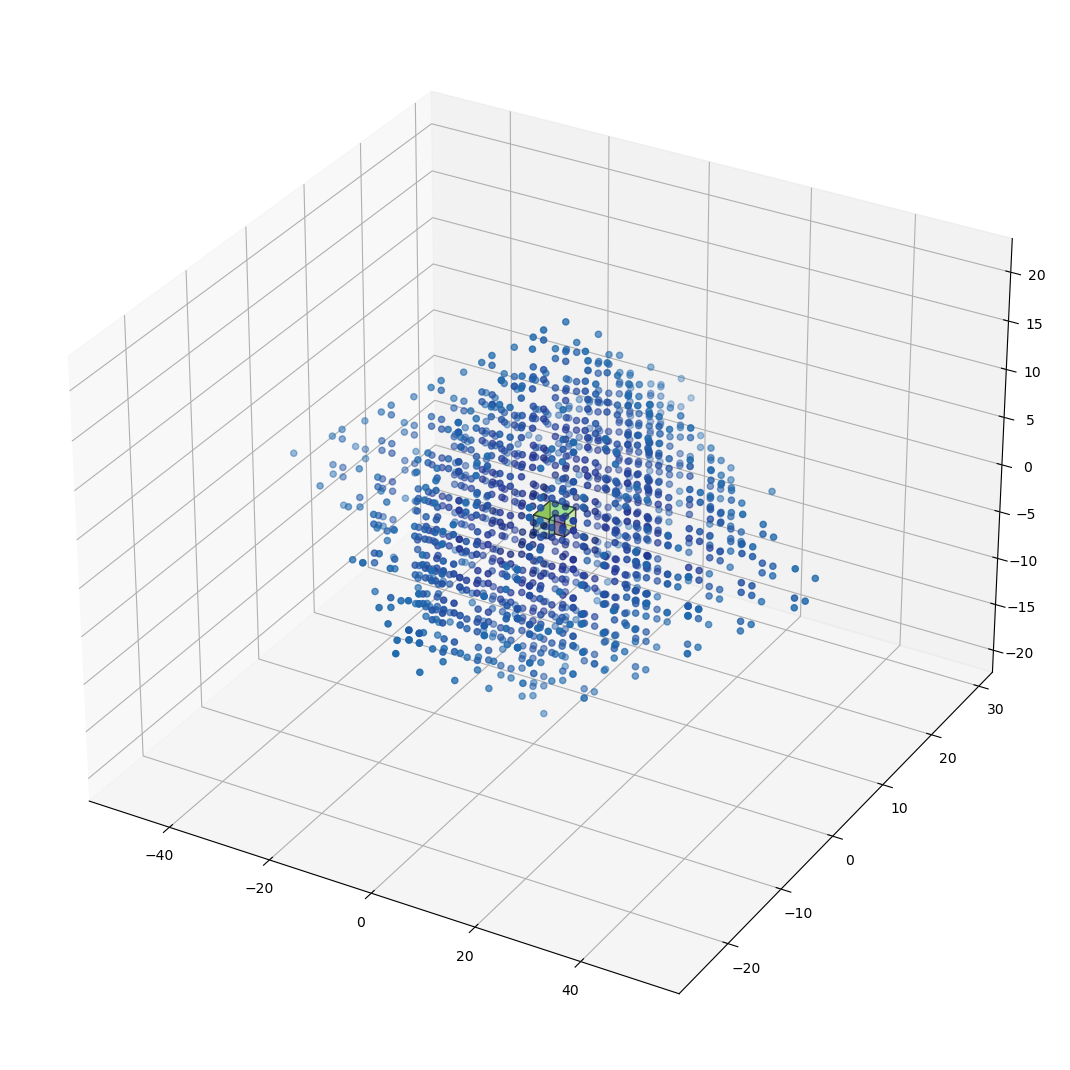

In [28]:
# specify signal source

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs_s[0], max_order=10, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True)
room.extrude(2., materials=pra.Material(0.2, 0.15))

# Set the ray tracing parameters
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([1., 1., 0.5], signal=signals[0])

# add two-microphone array
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=10)
fig.set_size_inches(18.5, 10.5)

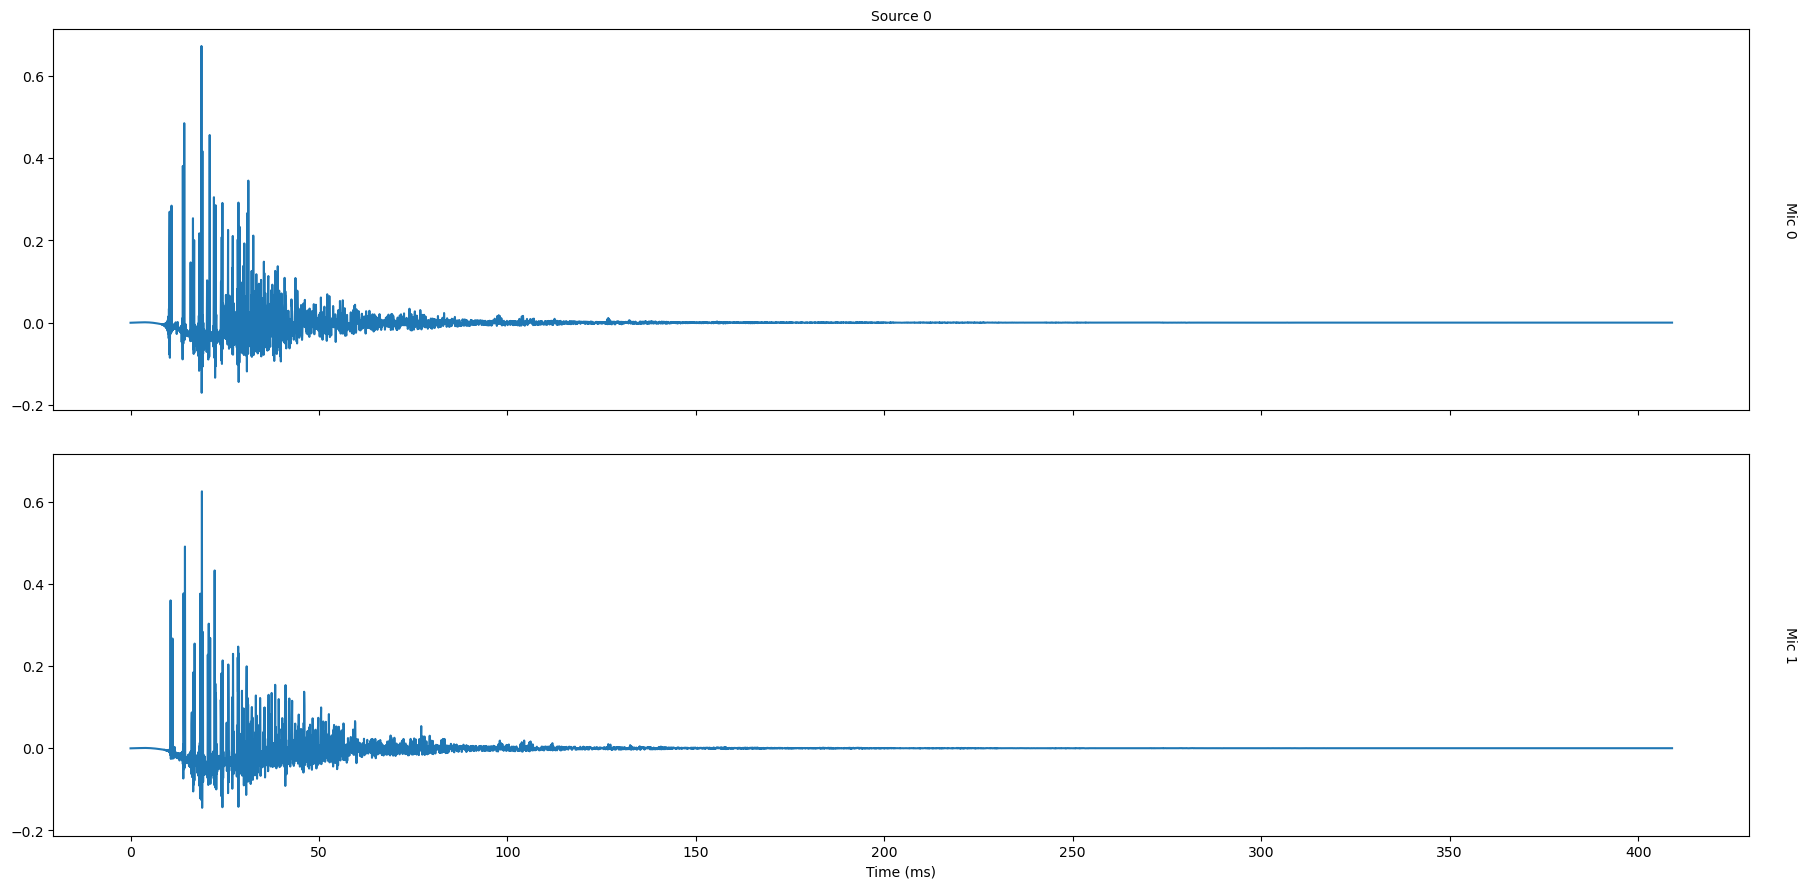

In [29]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20,10)

The RT60 is 258 ms


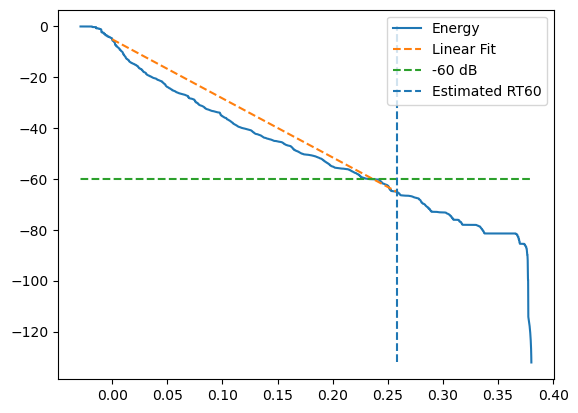

In [32]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

In [33]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 70544)


In [37]:
IPython.display.Audio(signals[0], rate=fs_s[0])

In [36]:
IPython.display.Audio(room.mic_array.signals[0,:],rate=fs_s[0])

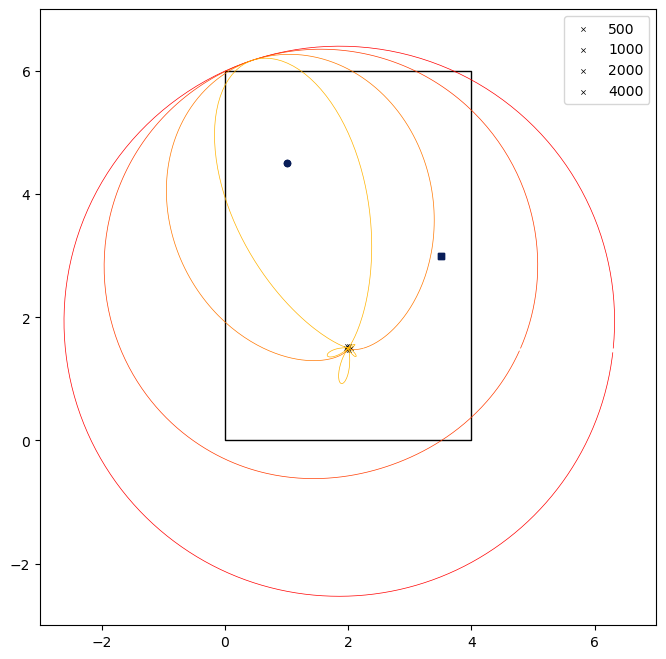

In [42]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples

# specify signal and noise source
signal = signals[0]
noise = signals[1]

# Create 4x6 shoebox room with source and interferer and simulate
room_bf = pra.ShoeBox([4,6], fs=fs, max_order=12)
source = np.array([1, 4.5])
interferer = np.array([3.5, 3.])
room_bf.add_source(source, delay=0., signal=signal)
room_bf.add_source(interferer, delay=0., signal=noise[:len(signal)])

# Create geometry equivalent to Amazon Echo
center = [2, 1.5]; radius = 37.5e-3
fft_len = 512
echo = pra.circular_2D_array(center=center, M=6, phi0=0, radius=radius)
echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)
mics = pra.Beamformer(echo, room_bf.fs, N=fft_len, Lg=Lg)
room_bf.add_microphone_array(mics)

# Compute DAS weights
mics.rake_delay_and_sum_weights(room_bf.sources[0][:1])

# plot the room and resulting beamformer before simulation
fig, ax = room_bf.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])
fig.set_size_inches(20, 8)
plt.xlim(-3,7)
plt.ylim(-3,7);

In [43]:
room_bf.compute_rir()
room_bf.simulate()

IPython.display.Audio(room_bf.mic_array.signals[-1,:],rate=fs)

In [44]:
signal_das = mics.process(FD=False)
IPython.display.Audio(signal_das, rate=fs)